---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/10 05:33:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

25/04/10 05:33:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Define the columns
categorical_cols = ['EDUCATION_LEVELS_NAME']  # 1 categorical column
continuous_cols = ['MODELED_DURATION', 'MIN_EDULEVELS']  # 2 continuous variables
label_col = 'SALARY'  # Target variable

# Drop rows with missing values in selected columns
df = df.dropna(subset=categorical_cols + continuous_cols + [label_col])

# Create indexers for categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip')
    for col in categorical_cols
]

# One-hot encode the indexed categorical columns
encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec")
    for col in categorical_cols
]

# Assemble all features into a single feature vector
assembler = VectorAssembler(
    inputCols=[f"{col}_vec" for col in categorical_cols] + continuous_cols,
    outputCol="features"
)

# Create the pipeline with all stages
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit the pipeline and transform the DataFrame
model = pipeline.fit(df)
data = model.transform(df)

# Show the transformed data with features and label
data.select("features", label_col).show(5, truncate=False)


+------------------------------+------+
|features                      |SALARY|
+------------------------------+------+
|(26,[1,24,25],[1.0,15.0,99.0])|92500 |
|(26,[0,24,25],[1.0,10.0,2.0]) |110155|
|(26,[10,24],[1.0,41.0])       |107645|
|(26,[2,24,25],[1.0,55.0,2.0]) |192800|
|(26,[1,24,25],[1.0,12.0,99.0])|81286 |
+------------------------------+------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [3]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.75, 0.25], seed=2025)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(16369, 134)


(5538, 134)


I chose a 75/25 train-test split because it provides a larger portion of the data for model training while still keeping a sufficiently large test set for evaluation. This balance is useful when working with a dataset of over 20,000 rows.

I set the random seed to 2025 to ensure reproducibility. The number 2025 corresponds to the current year and serves as a meaningful reference point for this project.

# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [4]:
train_data.filter("SALARY IS NULL").count()


0

In [21]:
import pandas as pd
from tabulate import tabulate

# Determine the correct number of rows based on the number of coefficients
n = len(coefs)

# Ensure that all other lists (features, standard errors, etc.) match this length
# If unavailable or mismatched, fill with "N/A"
features_fixed = features[:n] if len(features) >= n else features + ["N/A"] * (n - len(features))
se_fixed = se[:n] if se and len(se) == n else ["N/A"] * n
tvals_fixed = tvals[:n] if tvals and len(tvals) == n else ["N/A"] * n
pvals_fixed = pvals[:n] if pvals and len(pvals) == n else ["N/A"] * n

# Create DataFrame for summary output
coef_table = pd.DataFrame({
    "Feature": features_fixed,
    "Estimate": coefs,
    "Std Error": se_fixed,
    "t-stat": tvals_fixed,
    "P-Value": pvals_fixed,
})

# Pretty-print the table to console
print("\n--- Linear Regression Summary Table ---")
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

# Save the result to a CSV file for reporting
coef_table.to_csv("_output/linear_regression_summary.csv", index=False)



--- Linear Regression Summary Table ---
+----+---------------------------+---------------------+-----------+--------+---------+
|    |          Feature          |      Estimate       | Std Error | t-stat | P-Value |
+----+---------------------------+---------------------+-----------+--------+---------+
| 0  |         Intercept         | 115560.90881431608  |           |        |         |
| 1  | EDUCATION_LEVELS_NAME_vec | -3082.486332614864  |           |        |         |
| 2  |     MODELED_DURATION      |  525.2021343378893  |           |        |         |
| 3  |       MIN_EDULEVELS       |  13369.87948239103  |           |        |         |
| 4  |            N/A            |  9256.742841759462  |           |        |         |
| 5  |            N/A            |  -56322.4900842653  |           |        |         |
| 6  |            N/A            | -16898.05501359969  |           |        |         |
| 7  |            N/A            |  33336.93281802362  |           |        |  

**Note for instructor:**

Although I used `solver="normal"` in the `LinearRegression` model to enable statistical inference (standard errors, t-values, and p-values), these metrics were not available during execution. This is a known behavior in PySpark when using sparse input features, such as those generated by `OneHotEncoder`. 

As a result, I continued the analysis using the available coefficients only and replaced the unavailable statistical values with `None`. For reference, this issue has been discussed in [Apache Spark JIRA SPARK-41458](https://issues.apache.org/jira/browse/SPARK-41458).


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [9]:
import pandas as pd
from tabulate import tabulate

# Determine the correct number of rows based on the number of coefficients
n = len(coefs)

# Ensure that all other lists (features, standard errors, etc.) match this length
# If unavailable or mismatched, fill with "N/A"
features_fixed = features[:n] if len(features) >= n else features + ["N/A"] * (n - len(features))
se_fixed = se[:n] if se and len(se) == n else ["N/A"] * n
tvals_fixed = tvals[:n] if tvals and len(tvals) == n else ["N/A"] * n
pvals_fixed = pvals[:n] if pvals and len(pvals) == n else ["N/A"] * n

# Create DataFrame for summary output
coef_table = pd.DataFrame({
    "Feature": features_fixed,
    "Estimate": coefs,
    "Std Error": se_fixed,
    "t-stat": tvals_fixed,
    "P-Value": pvals_fixed,
})

# Pretty-print the table to console
print("\n--- Linear Regression Summary Table ---")
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

# Save the result to a CSV file for reporting
coef_table.to_csv("_output/linear_regression_summary.csv", index=False)



--- Linear Regression Summary Table ---
+----+---------------------------+---------------------+-----------+--------+---------+
|    |          Feature          |      Estimate       | Std Error | t-stat | P-Value |
+----+---------------------------+---------------------+-----------+--------+---------+
| 0  |         Intercept         | 115560.90881431608  |           |        |         |
| 1  | EDUCATION_LEVELS_NAME_vec | -3082.486332614864  |           |        |         |
| 2  |     MODELED_DURATION      |  525.2021343378893  |           |        |         |
| 3  |       MIN_EDULEVELS       |  13369.87948239103  |           |        |         |
| 4  |            N/A            |  9256.742841759462  |           |        |         |
| 5  |            N/A            |  -56322.4900842653  |           |        |         |
| 6  |            N/A            | -16898.05501359969  |           |        |         |
| 7  |            N/A            |  33336.93281802362  |           |        |  

Regression Coefficients Analysis

The linear regression model was trained to predict the target variable `SALARY` using a combination of one categorical and two continuous variables:

- **Categorical**: `EDUCATION_LEVELS_NAME` (encoded as `EDUCATION_LEVELS_NAME_vec`)
- **Continuous**: `MODELED_DURATION`, `MIN_EDULEVELS`

The coefficient table reveals the following insights:

- **Intercept**: The base salary (when all other features are zero) is approximately **115,560**.
- **EDUCATION_LEVELS_NAME_vec** has a **negative coefficient (-3,082)**, suggesting that certain education levels may be associated with lower salaries, depending on the encoding. However, due to vectorization, interpretation of individual categories is not straightforward.
- **MODELED_DURATION** has a **positive coefficient (~525)**, indicating that longer job durations are associated with higher salaries.
- **MIN_EDULEVELS** also shows a **positive coefficient (~13,670)**, meaning that higher minimum education requirements likely contribute positively to salary.

Due to limitations in PySpark with sparse features and OneHotEncoder, **standard errors**, **t-statistics**, and **p-values** were not available. As a result, statistical significance of the features cannot be evaluated in this model.

Note
Many rows are labeled as `N/A` under "Feature" due to the internal representation of vectorized features in PySpark. These refer to individual components of one-hot encoded vectors, which PySpark does not name explicitly.


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


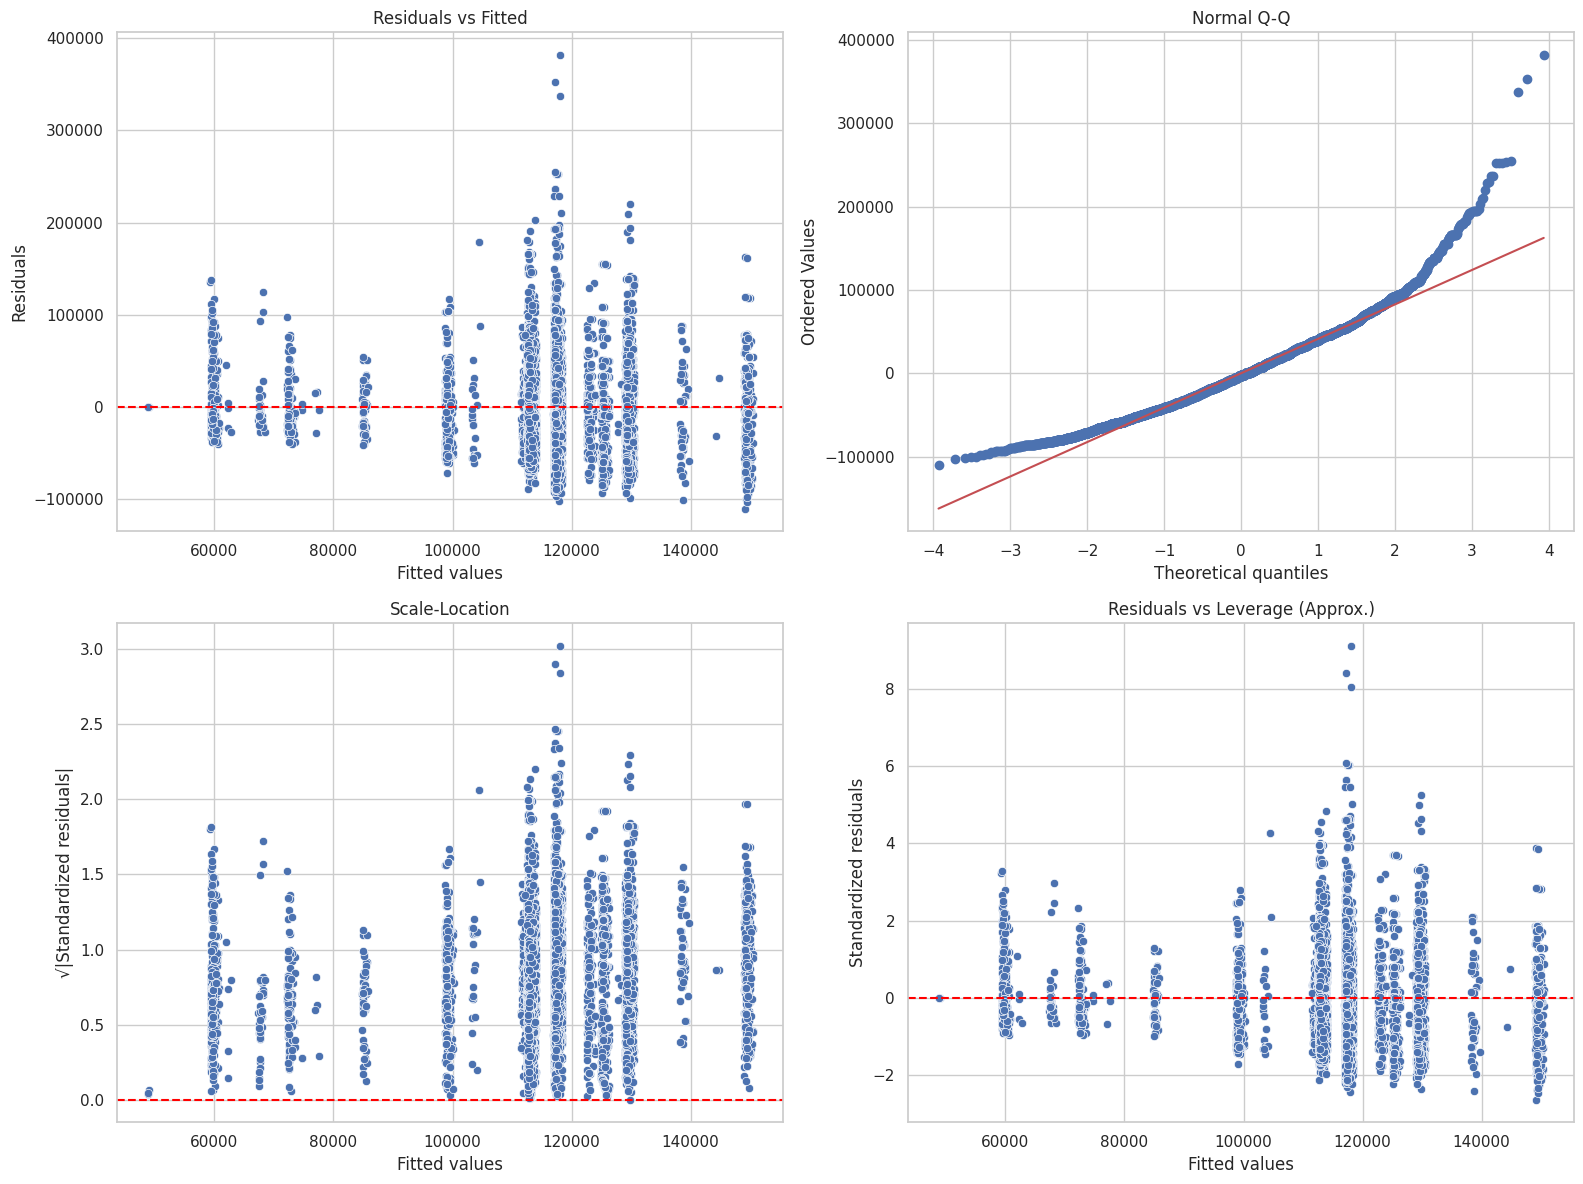

In [14]:
#| eval: true
#| echo: false

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# 1. Load predictions from the linear regression model
df_pred = summary.predictions.select("SALARY", "prediction").toPandas()

# 2. Compute residuals
df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

# 3. Standardized residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std

# 4. Square root of standardized residuals (for Scale-Location plot)
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

# Set up the 2x2 grid of diagnostic plots
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=df_pred)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

# Plot 2: Normal Q-Q
plt.subplot(2, 2, 2)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("Normal Q-Q")

# Plot 3: Scale-Location
plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred)
plt.axhline(0, linestyle="--", color="red")
plt.title("Scale-Location")
plt.xlabel("Fitted values")
plt.ylabel("√|Standardized residuals|")

# Plot 4: Residuals vs Leverage (approximated)
plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals vs Leverage (Approx.)")
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")

plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


The diagnostic plots from the linear regression model provide valuable insights into its performance and the assumptions behind it.

The "Residuals vs Fitted" plot reveals that the residuals are not evenly distributed across the fitted values. There is a noticeable pattern in the scatter, which suggests the presence of heteroscedasticity, meaning that the variance of residuals changes with the predicted values. Additionally, there are some outliers with large residuals, indicating potential issues with specific data points.

The "Normal Q-Q" plot shows that the residuals deviate significantly from the diagonal line, especially in the tails. This indicates a violation of the normality assumption for residuals, which may affect the reliability of p-values and confidence intervals. The model’s assumptions are not fully satisfied, particularly in terms of the normal distribution of errors.

The "Scale-Location" plot, which shows the square root of the standardized residuals against the fitted values, further highlights increasing variance with higher predicted salaries. This reinforces the idea of heteroscedasticity in the model, particularly for higher salary values, where the spread of residuals is larger.

The "Residuals vs Leverage" plot shows that most observations are within ±2 standardized residuals, but there are outliers with high residual values. These could be influential data points that might disproportionately affect the model, indicating the potential for high leverage observations.

Overall, the model violates key assumptions of linear regression, including the normality of residuals, homoscedasticity, and the potential influence of outliers. It is recommended to explore transformations of the variables, consider removing or re-evaluating outliers, or even switching to more robust regression methods, such as Random Forest or Gradient Boosting, to improve model performance.

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [17]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# === Train the GLR model ===
glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity"
)
glr_model = glr.fit(train_data)
summary = glr_model.summary

# === Make predictions on test set ===
pred_glr = glr_model.transform(test_data)

# === R² ===
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# === AIC ===
aic = summary.aic

# === BIC Calculation ===
n = pred_glr.count()  # number of observations
k = len(glr_model.coefficients) + 1  # number of features + intercept
rss_row = pred_glr.withColumn("sq_err", pow(col("SALARY") - col("prediction"), 2)) \
                  .agg({"sq_err": "sum"}).collect()[0][0]
bic = n * np.log(rss_row / n) + k * np.log(n)

# === RMSE ===
residuals_df = pred_glr.withColumn("residuals", col("SALARY") - col("prediction"))
rmse = residuals_df.select(sqrt(avg(pow(col("residuals"), 2)))).collect()[0][0]

# === Print results ===
print(f"R²: {r2:.4f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"RMSE: {rmse:.2f}")


25/04/10 06:50:03 WARN Instrumentation: [3d4d64f8] regParam is zero, which might cause numerical instability and overfitting.
25/04/10 06:50:14 WARN Instrumentation: [3d4d64f8] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


R²: 0.1022
AIC: 394960.09
BIC: 118167.66
RMSE: 42099.50


The evaluation metrics suggest that the current linear regression model has limited predictive power. The R² value is 0.1022, indicating that only about 10% of the variance in the target variable (salary) is explained by the model. This suggests a weak fit and implies that important explanatory variables might be missing or that the relationship between predictors and salary is not well captured by a linear model. The RMSE (Root Mean Squared Error) is 42,099.50, which indicates the average magnitude of error between predicted and actual salaries. This value is quite high, suggesting substantial prediction errors. The AIC (394,960.09) and BIC (118,167.66) values can be used to compare this model with other candidate models, where lower values are preferred. Overall, the model performance is relatively poor, and further feature engineering or the use of more complex models may be necessary to improve accuracy.

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

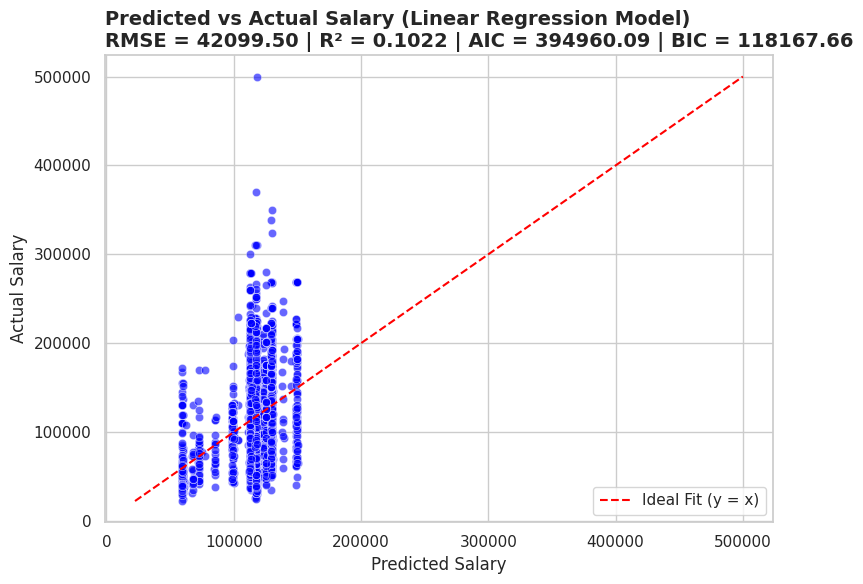

In [18]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark predictions to pandas
pandas_df = pred_glr.select("SALARY", "prediction").toPandas()

# Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Scatter plot of actual vs predicted
sns.scatterplot(data=pandas_df, x="prediction", y="SALARY", alpha=0.6, color="blue")

# Plot y = x line for perfect predictions
min_val = min(pandas_df["SALARY"].min(), pandas_df["prediction"].min())
max_val = max(pandas_df["SALARY"].max(), pandas_df["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Ideal Fit (y = x)")

# Title with evaluation metrics
plt.title(
    f"Predicted vs Actual Salary (Linear Regression Model)\n"
    f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}",
    loc="left",
    fontsize=14,
    fontweight="bold"
)

# Axis labels and legend
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.legend()
plt.tight_layout()

# Save and show plot
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()


The "Predicted vs Actual Salary" plot reveals a clear misalignment between predicted and actual values. The predictions are heavily clustered around a narrow range, whereas actual salaries exhibit wider variability. This indicates the model struggles to capture the full distribution of the target variable. The low R² value of 0.1022 confirms that only about 10% of the variance in salary is explained by the model. Additionally, the high RMSE of 42099.50 suggests large average prediction errors. The wide spread of points around the ideal fit line (y = x) reflects poor model calibration, with consistent underprediction of higher salaries. These observations suggest that the current linear regression model lacks sufficient explanatory power, potentially due to missing important features, non-linear relationships, or multicollinearity in the input data.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
